## Understanding Katz Centrality in Networks

This notebook demonstrates how Katz centrality works, implements it from scratch using matrix operations, and shows how it effectively solves the problems that eigenvector centrality faces with directed acyclic graphs (DAGs).

### Learning Objectives

- Understand the mathematical definition and intuition behind Katz centrality
- Learn why eigenvector centrality fails for DAGs and how Katz centrality resolves this
- Implement Katz centrality from scratch and compare with NetworkX implementation
- Visualize the differences between eigenvector and Katz centrality on DAGs

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. What is Katz Centrality?

Katz centrality is an extension of eigenvector centrality designed to overcome its limitations, particularly for directed graphs. It measures influence by calculating:

- How well-connected a node is (like degree centrality)
- The quality of those connections (like eigenvector centrality)
- With an added **baseline score** that ensures even nodes with no incoming connections get some centrality

### Mathematical Definition

If x is the centrality vector, A is the adjacency matrix, α is the attenuation factor, and β is the baseline score, Katz centrality is defined by:

$$x = \alpha A x + \beta$$

Which can be rewritten as:

$$x = (I - \alpha A)^{-1} \beta$$

Where:
- $\alpha$ is the attenuation factor (must be < 1/λ, where λ is the largest eigenvalue of A)
- $\beta$ is typically a vector of all ones, giving each node a baseline centrality

### Key Differences from Eigenvector Centrality

Eigenvector centrality defines the centrality recursively as:

$$\lambda x = Ax$$

The key difference is that Katz centrality adds the constant term β, which prevents the centrality from becoming zero even for nodes with no incoming links.

## 2. Why Eigenvector Centrality Fails for DAGs

To understand why Katz centrality is necessary for DAGs, let's first recall the problem with eigenvector centrality in these graphs:

### The Zero-Centrality Cascade

In a DAG:
1. Source nodes have no incoming edges, so they get zero eigenvector centrality
2. This zero centrality propagates to nodes that only receive links from source nodes
3. Eventually, all nodes can end up with zero centrality

### Mathematical Explanation

For a DAG, the adjacency matrix can be reordered to be strictly upper triangular. Such matrices have all eigenvalues equal to zero, making the eigenvector centrality equation become $0x = Ax$, which has no meaningful solution for centrality.

In [ ]:
# Let's implement Katz centrality from scratch using the power iteration method
def compute_katz_centrality(adjacency_matrix, alpha=0.1, beta=1.0, 
                            max_iterations=100, tolerance=1e-6, 
                            normalize=True, transpose_for_directed=True):
    """
    Compute Katz centrality from scratch using the power iteration method.
    
    Parameters:
    -----------
    adjacency_matrix : numpy.ndarray
        The adjacency matrix of the graph.
    alpha : float
        Attenuation factor (should be < 1/largest eigenvalue).
    beta : float
        Base centrality score given to all nodes.
    max_iterations : int
        Maximum number of iterations.
    tolerance : float
        Convergence threshold (relative change).
    normalize : bool
        Whether to normalize the resulting centrality vector.
    transpose_for_directed : bool
        Whether to transpose the matrix for directed graphs to match NetworkX's behavior.
        
    Returns:
    --------
    numpy.ndarray
        Katz centrality scores.
    """
    n = adjacency_matrix.shape[0]
    # Initialize with beta for each node
    x = np.full(n, beta)
    
    # For directed graphs, transpose the matrix if requested
    if transpose_for_directed:
        adjacency_matrix = adjacency_matrix.T
    
    for i in range(max_iterations):
        # Compute the new centrality scores using the power iteration step
        x_new = alpha * (adjacency_matrix @ x) + beta
        
        # Relative convergence check
        norm_x = np.linalg.norm(x)
        if norm_x != 0 and np.linalg.norm(x_new - x) / norm_x < tolerance:
            print(f"Katz converged after {i+1} iterations")
            x = x_new
            break
        x = x_new
    else:
        print(f"Warning: Katz did not converge after {max_iterations} iterations")
        
    # Normalize the result if requested, with a check to prevent division by zero
    if normalize:
        norm_x = np.linalg.norm(x)
        if norm_x != 0:
            x = x / norm_x
            
    return x

## 3. Creating Test Graphs

Let's create two test graphs to demonstrate how Katz centrality works:
1. A simple undirected graph
2. A directed acyclic graph (DAG) where eigenvector centrality fails

In [3]:
# Create an undirected graph
G_undirected = nx.Graph()
G_undirected.add_edges_from([
    (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)
])

# Create a directed acyclic graph (DAG)
G_dag = nx.DiGraph()
G_dag.add_edges_from([
    (0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)
])

# Verify the DAG property
print(f"Is our directed graph a DAG? {nx.is_directed_acyclic_graph(G_dag)}")

# Get the adjacency matrices
A_undirected = nx.adjacency_matrix(G_undirected).toarray()
A_dag = nx.adjacency_matrix(G_dag).toarray()

# Display adjacency matrix of the DAG
print("\nAdjacency matrix of the DAG:")
print(A_dag)

Is our directed graph a DAG? True

Adjacency matrix of the DAG:
[[0 1 1 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


## 4. Computing Katz Centrality

Now let's compute Katz centrality for both our undirected graph and DAG, and compare our implementation with the NetworkX implementation.

In [4]:
# First, let's check the largest eigenvalues of our matrices to determine safe alpha values
eigenvalues_undirected = np.linalg.eigvals(A_undirected)
eigenvalues_dag = np.linalg.eigvals(A_dag)
max_eigen_undirected = max(abs(eigenvalues_undirected))
max_eigen_dag = max(abs(eigenvalues_dag))

print(f"Largest eigenvalue of undirected graph: {max_eigen_undirected:.4f}")
print(f"Safe alpha for undirected graph: < {1/max_eigen_undirected:.4f}")
print(f"Largest eigenvalue of DAG: {max_eigen_dag:.4f}")
print(f"Safe alpha for DAG: {'any value' if max_eigen_dag == 0 else f'< {1/max_eigen_dag:.4f}'}")

# Choose alpha values for our graphs
alpha_undirected = 0.5 / max_eigen_undirected  # Just to be safe
alpha_dag = 0.1  # For DAG, any value works since the largest eigenvalue is 0
beta = 1.0

print(f"\nUsing alpha={alpha_undirected:.4f} for undirected graph")
print(f"Using alpha={alpha_dag:.4f} for DAG")

Largest eigenvalue of undirected graph: 2.7093
Safe alpha for undirected graph: < 0.3691
Largest eigenvalue of DAG: 0.0000
Safe alpha for DAG: any value

Using alpha=0.1846 for undirected graph
Using alpha=0.1000 for DAG


In [5]:
# Compute Katz centrality for undirected graph
our_katz_undirected = compute_katz_centrality(A_undirected, alpha=alpha_undirected, beta=beta)

# Compute with NetworkX for comparison
nx_katz_undirected = nx.katz_centrality(G_undirected, alpha=alpha_undirected, beta=beta)
nx_katz_values_undirected = np.array([nx_katz_undirected[i] for i in range(len(G_undirected))])

# Print results for undirected graph
print("Katz centrality for undirected graph:")
print("-----------------------------------")
print("Our implementation:")
for i, c in enumerate(our_katz_undirected):
    print(f"Node {i}: {c:.6f}")
    
print("\nNetworkX implementation:")
for i, c in enumerate(nx_katz_values_undirected):
    print(f"Node {i}: {c:.6f}")

# Calculate similarity
similarity = np.dot(our_katz_undirected, nx_katz_values_undirected) / (np.linalg.norm(our_katz_undirected) * np.linalg.norm(nx_katz_values_undirected))
print(f"\nCosine similarity between implementations: {similarity:.6f}")

Katz converged after 19 iterations
Katz centrality for undirected graph:
-----------------------------------
Our implementation:
Node 0: 0.345929
Node 1: 0.411097
Node 2: 0.411097
Node 3: 0.418280
Node 4: 0.392034
Node 5: 0.326867
Node 6: 0.326867

NetworkX implementation:
Node 0: 0.345929
Node 1: 0.411097
Node 2: 0.411097
Node 3: 0.418280
Node 4: 0.392034
Node 5: 0.326867
Node 6: 0.326867

Cosine similarity between implementations: 1.000000


In [6]:
# Now compute Katz centrality for the DAG
our_katz_dag = compute_katz_centrality(A_dag, alpha=alpha_dag, beta=beta)

# Compute with NetworkX for comparison
nx_katz_dag = nx.katz_centrality(G_dag, alpha=alpha_dag, beta=beta)
nx_katz_values_dag = np.array([nx_katz_dag[i] for i in range(len(G_dag))])

# Print results for DAG
print("Katz centrality for DAG:")
print("----------------------")
print("Our implementation:")
for i, c in enumerate(our_katz_dag):
    print(f"Node {i}: {c:.6f}")
    
print("\nNetworkX implementation:")
for i, c in enumerate(nx_katz_values_dag):
    print(f"Node {i}: {c:.6f}")

# Calculate similarity
similarity = np.dot(our_katz_dag, nx_katz_values_dag) / (np.linalg.norm(our_katz_dag) * np.linalg.norm(nx_katz_values_dag))
print(f"\nCosine similarity between implementations: {similarity:.6f}")

Katz converged after 6 iterations
Katz centrality for DAG:
----------------------
Our implementation:
Node 0: 0.329958
Node 1: 0.362953
Node 2: 0.399249
Node 3: 0.406178
Node 4: 0.370575
Node 5: 0.367015
Node 6: 0.403717

NetworkX implementation:
Node 0: 0.329958
Node 1: 0.362953
Node 2: 0.399249
Node 3: 0.406178
Node 4: 0.370575
Node 5: 0.367015
Node 6: 0.403717

Cosine similarity between implementations: 1.000000


## 5. Visualizing Katz Centrality

Let's visualize how Katz centrality works on both our undirected graph and DAG. This will help us see how it differs from eigenvector centrality, especially on the DAG.

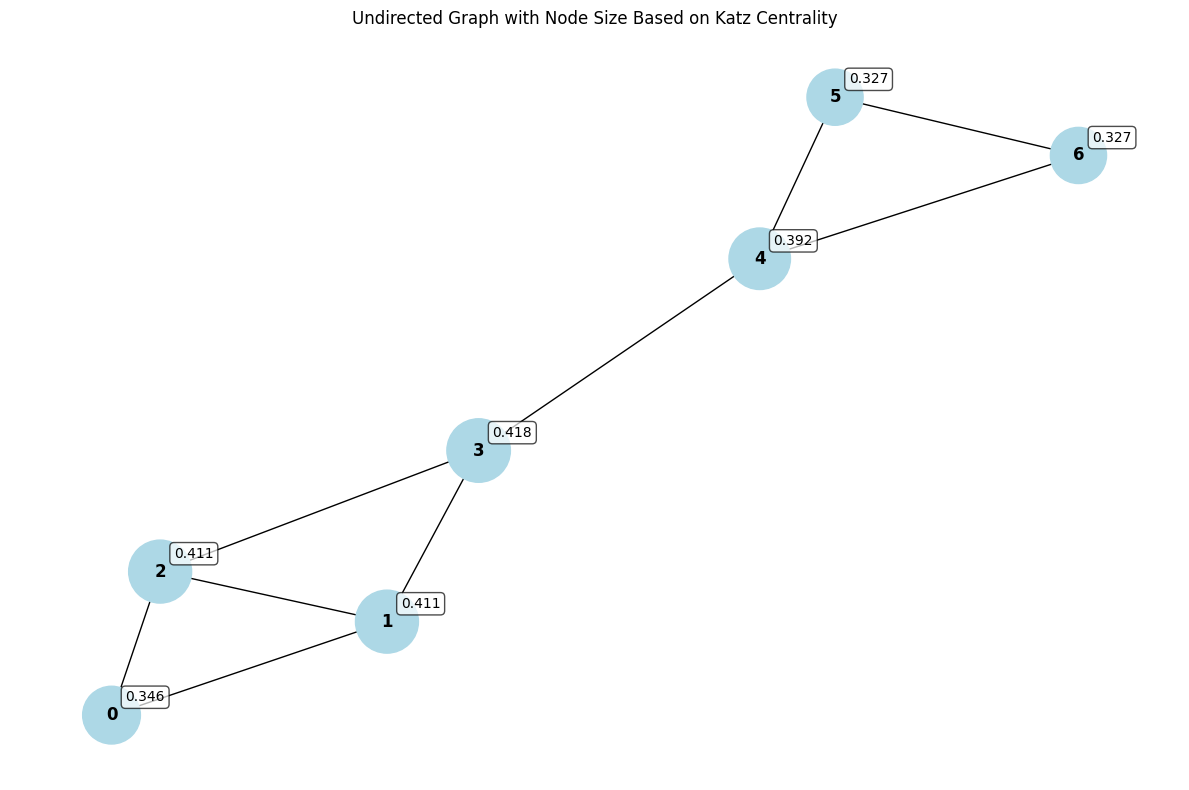

In [7]:
# Visualize Katz centrality on undirected graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_undirected, seed=42)

# Create node sizes based on Katz centrality (scaled for better visualization)
node_sizes = [nx_katz_undirected[i] * 5000 for i in range(len(G_undirected))]

# Draw nodes with variable sizes
nx.draw_networkx_nodes(G_undirected, pos, node_color='lightblue',
                      node_size=node_sizes)

# Draw edges
nx.draw_networkx_edges(G_undirected, pos)

# Draw labels
nx.draw_networkx_labels(G_undirected, pos, font_weight='bold')

# Add centrality values as annotations
for i, (node, centrality) in enumerate(nx_katz_undirected.items()):
    plt.annotate(f"{centrality:.3f}", 
                 xy=pos[node], xytext=(10, 10), 
                 textcoords="offset points",
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.title("Undirected Graph with Node Size Based on Katz Centrality")
plt.axis('off')
plt.tight_layout()
plt.show()

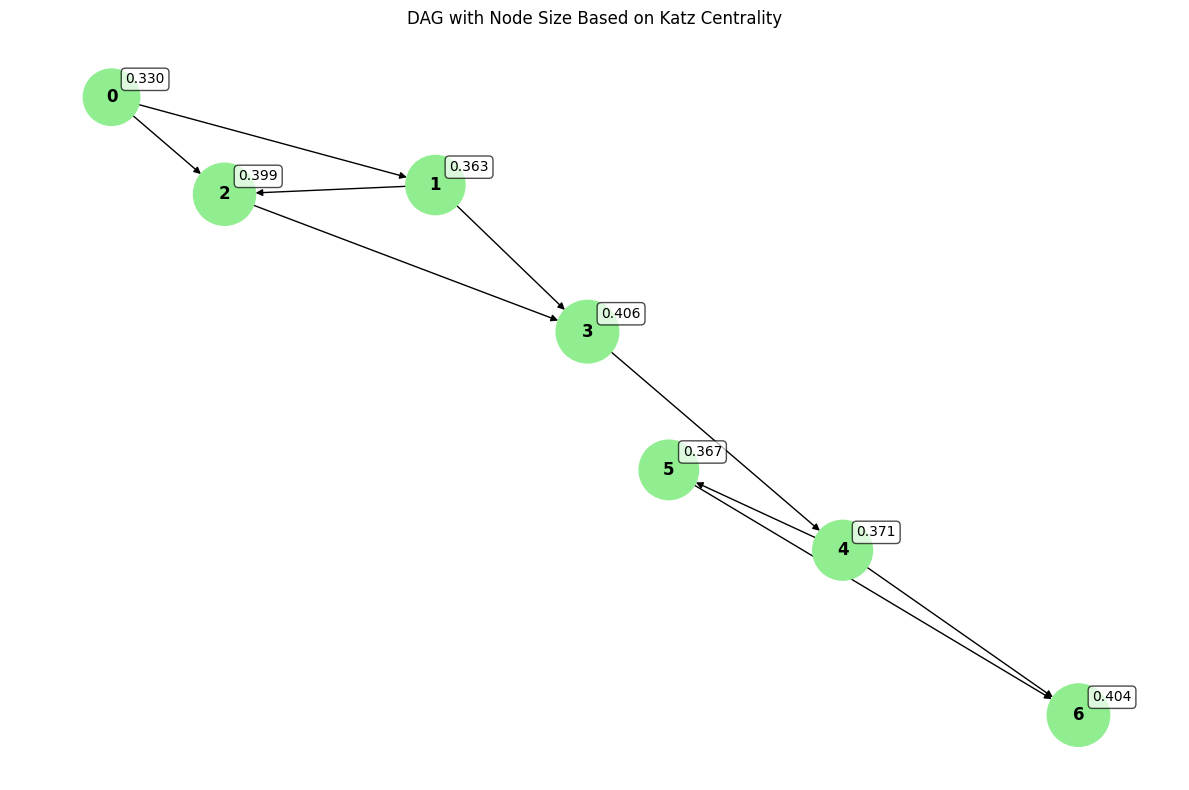

In [8]:
# Visualize Katz centrality on DAG
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_dag, seed=42)

# Create node sizes based on Katz centrality
node_sizes = [nx_katz_dag[i] * 5000 for i in range(len(G_dag))]

# Draw nodes with variable sizes
nx.draw_networkx(G_dag, pos, with_labels=True, arrows=True, node_color='lightgreen', node_size=node_sizes, font_weight='bold')

# Add centrality values as annotations
for i, (node, centrality) in enumerate(nx_katz_dag.items()):
    plt.annotate(f"{centrality:.3f}", 
                 xy=pos[node], xytext=(10, 10), 
                 textcoords="offset points",
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.title("DAG with Node Size Based on Katz Centrality")
plt.axis('off')
plt.tight_layout()
plt.show()

## 6. Step-by-Step Analysis of Katz Centrality in DAGs

Let's analyze how Katz centrality overcomes the zero-centrality problem that affects eigenvector centrality in DAGs. We'll trace through the iterations of the algorithm to see the differences.

Source nodes (no incoming edges): [0]
Sink nodes (no outgoing edges): [6]

Initial centrality vector: [1. 1. 1. 1. 1. 1. 1.]

After iteration 1:
Centrality vector: [1.2 1.2 1.1 1.1 1.2 1.1 1. ]

After iteration 2:
Centrality vector: [1.23 1.22 1.11 1.12 1.21 1.1  1.  ]

After iteration 3:
Centrality vector: [1.233 1.223 1.112 1.121 1.21  1.1   1.   ]

After iteration 4:
Centrality vector: [1.2335 1.2233 1.1121 1.121  1.21   1.1    1.    ]

After iteration 5:
Centrality vector: [1.23354 1.22331 1.1121  1.121   1.21    1.1     1.     ]


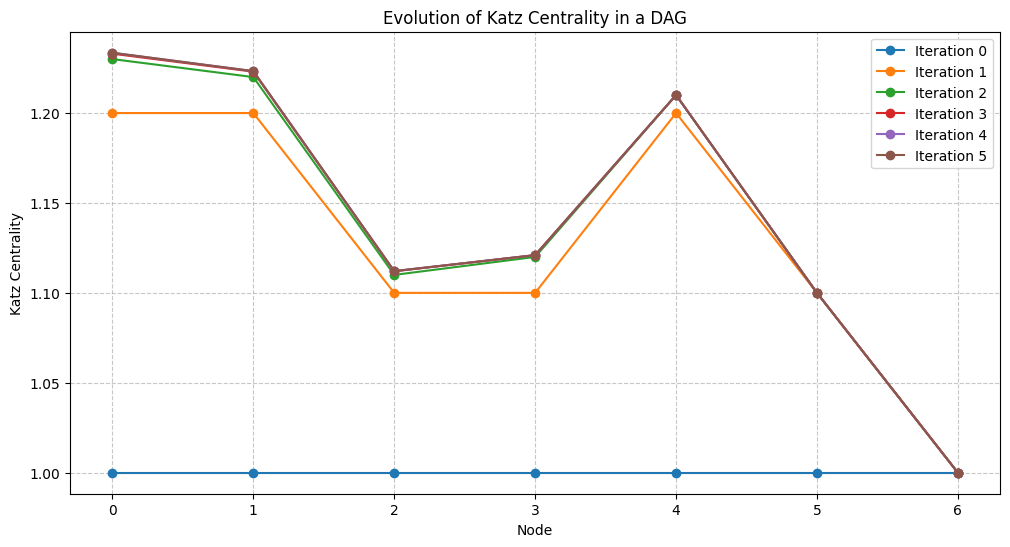

In [9]:
# Step-by-step analysis
print("Source nodes (no incoming edges):", [n for n in G_dag.nodes() if G_dag.in_degree(n) == 0])
print("Sink nodes (no outgoing edges):", [n for n in G_dag.nodes() if G_dag.out_degree(n) == 0])

# Initialize
x = np.ones(len(G_dag)) * beta  # Initial vector with beta
print("\nInitial centrality vector:", x)

# Track the evolution of centrality over multiple iterations
iterations = 5
centrality_history = [x.copy()]

for i in range(iterations):
    # Apply the Katz centrality equation: x = αAx + β
    x = alpha_dag * (A_dag @ x) + beta
    print(f"\nAfter iteration {i+1}:")
    print(f"Centrality vector: {x}")
    centrality_history.append(x.copy())

# Visualize how the centrality evolves
plt.figure(figsize=(12, 6))
for i, centrality in enumerate(centrality_history):
    plt.plot(range(len(G_dag)), centrality, marker='o', label=f"Iteration {i}")
    
plt.xlabel("Node")
plt.ylabel("Katz Centrality")
plt.title("Evolution of Katz Centrality in a DAG")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## 7. How Katz Centrality Solves the DAG Problem

Let's dive deeper into understanding exactly how Katz centrality overcomes the limitations of eigenvector centrality in DAGs:

### The Fundamental Difference

- **Eigenvector Centrality**: $\lambda x = Ax$
  - Centrality is based solely on the centrality of incoming neighbors
  - Source nodes (no incoming links) get zero centrality, creating a cascade of zeros

- **Katz Centrality**: $x = \alpha Ax + \beta$
  - Adds a baseline score $\beta$ to every node
  - Even source nodes get at least a value of $\beta$
  - This non-zero value then propagates through the network

### The Mathematical Insight

The solution to the Katz equation can also be written as:

$$x = (I - \alpha A)^{-1}\beta$$

This can be expanded into an infinite series:

$$x = \beta(I + \alpha A + \alpha^2A^2 + \alpha^3A^3 + ...)$$

This means Katz centrality considers walks of all lengths through the network, with longer walks given less weight via $\alpha^k$.

### Key Insights from Our Results

1. **Source nodes**: Start with value $\beta$, then only contribute to others but don't receive
2. **Middle nodes**: Get $\beta$ plus contribution from incoming neighbors
3. **Sink nodes**: Often have highest centrality because they accumulate from all paths

The parameter $\alpha$ controls how quickly influence attenuates over distance, while $\beta$ ensures a minimum score for all nodes.

By addressing these mathematical limitations, Katz centrality offers a robust alternative for analyzing DAGs and other directed networks where eigenvector centrality fails.

## 8. Conclusion: When to Use Katz Centrality

### Best Use Cases for Katz Centrality

1. **Directed Acyclic Graphs (DAGs)**:
   - Citation networks
   - Dependency graphs
   - Hierarchical organizational structures

2. **Networks with Source Nodes**:
   - Any network where some nodes have no incoming edges

3. **When You Need Absolute Rather Than Relative Importance**:
   - The β parameter gives a baseline importance to all nodes

4. **When Fine-Tuning Influence Decay is Important**:
   - The α parameter allows you to control how quickly influence attenuates

### Pros of Katz Centrality

- Works on all types of networks, including DAGs
- Provides meaningful values for all nodes
- Flexible parameterization to fit different network scenarios
- Considers walks of all possible lengths

### Cons of Katz Centrality

- Requires careful selection of α parameter
- More computationally expensive than eigenvector centrality
- Results can be sensitive to parameter choices

### Key Takeaways

1. **Katz centrality extends eigenvector centrality** by adding a baseline score to all nodes
2. This makes it effective for **analyzing any graph structure**, including DAGs
3. The parameters α and β provide **flexibility** to adapt to different network properties
4. Katz centrality is especially valuable for **identifying important nodes in hierarchical structures**

By understanding both the theory and practical implementation of Katz centrality, you can apply it effectively to a wide range of network analysis problems where eigenvector centrality might fail or provide misleading results.